In [2]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from os.path import join
from tqdm import tqdm

import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms

from skimage.io import imread, imshow
from skimage.transform import resize
from skimage.feature import hog
from skimage import data, exposure

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
%cd drive/MyDrive/18752_project/

/content/drive/MyDrive/18752_project


In [12]:
data = open("Data/data_files.txt").read().splitlines()
labels = np.loadtxt("Data/data_labels.txt", np.int32)

In [14]:
train_data_set = []
for img_name in data:
    img_path = 'Data/{}.png'.format(img_name)
    img = plt.imread(img_path)
    img = img[:, :, 0]
    img = resize(img, (64,64)) 
    train_data_set.append(img)

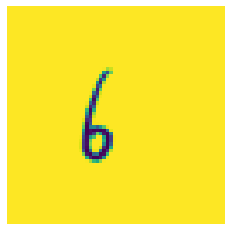

In [ ]:
# Sample Image
sample_idx = 50
sample_img = train_data_set[sample_idx]
plt.figure()
plt.axis("off")
plt.imshow(sample_img)
plt.show()

In [ ]:
# Feature Extraction 1: Histogram of Gradient (HOG)

def hog_features_extractor(img):
    fd, hog_img = hog(img, orientations=9, pixels_per_cell=(8, 8), cells_per_block=(2, 2), 
                  visualize=True, multichannel=False)
    return fd, hog_img

In [ ]:
# HOG Features for the Dataset

hog_features, hog_imgs = [], []

for img in train_data_set:
    fd, hog_img = hog_features_extractor(img)
    hog_features.append(fd)
    hog_imgs.append(hog_img)

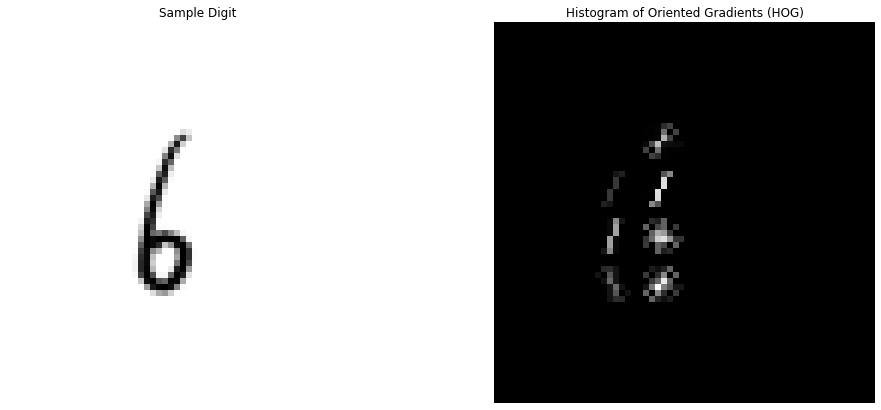

In [ ]:
# sample HOG visualization

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7), sharex=True, sharey=True) 

ax1.imshow(sample_img, cmap=plt.cm.gray) 
ax1.set_title('Sample Digit')
ax1.axis("off")

hog_rescaled = exposure.rescale_intensity(hog_imgs[sample_idx], in_range=(0, 10)) 

ax2.imshow(hog_rescaled, cmap=plt.cm.gray) 
ax2.set_title('Histogram of Oriented Gradients (HOG)')
ax2.axis("off")

plt.savefig("hog.png", dpi=125)
plt.show()

In [ ]:
# Feature Extraction 2: SIFT Corner Detection

def sift_feature_extractor(img):
    sift = cv2.SIFT_create()
    key_points = sift.detect(img, None)
    return key_points

In [ ]:
# generate SIFT keypoints for the dataset
kpts = []
for img_name in data:
    img_path = '../data/{}.png'.format(img_name)
    img = cv2.imread(img_path)
    key_points = sift_feature_extractor(img)
    kpts.append(key_points)

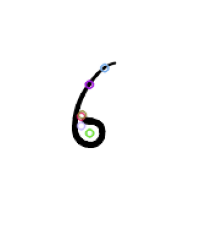

In [ ]:
# sample SIFT keypoints

img = cv2.imread('../data/img_{}.png'.format(sample_idx))
key_points = sift_feature_extractor(img)

img_ = cv2.drawKeypoints(img, key_points, img)

plt.figure()
plt.axis('off')
plt.imshow(img_)
plt.savefig("SIFT.png", dpi=300)
plt.show()

In [57]:
# Feature Extraction 3: Neural Network

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return x, output

In [52]:
# Data Loader

transform = transforms.Compose([transforms.ToTensor(), 
                                transforms.Normalize((0.1307,), (0.3081,))])
train_loader = torch.utils.data.DataLoader(datasets.MNIST('../data', train=True, download=True, transform=transform),
                                           batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(datasets.MNIST('../data', train=False, transform=transform), 
                                          batch_size=1028, shuffle=False)

In [58]:
model = CNN().to(device)
optimizer = optim.Adam(model.parameters())

In [59]:
def train(model, optimizer, data_loader, n_epochs=50):
    model.train()
    
    train_loss, train_acc = [], []
    for i in tqdm(range(n_epochs)):
        total_loss = 0
        avg_acc = 0
        
        for data, target in data_loader:
            target = target.type(torch.LongTensor)
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            x, output = model(data)
            acc = get_acc(target, output)
            loss = F.nll_loss(output, target)
            loss.backward()
            optimizer.step()    
            total_loss += loss.item()
            avg_acc += acc

        train_acc.append(avg_acc / len(data_loader))
        train_loss.append(total_loss / len(data_loader))
            
    return train_loss, train_acc

In [60]:
def get_acc(y, probs):
    y, probs = y.to(device), probs.to(device)
    y_pred = probs.argmax(1)
    acc = torch.sum(y == y_pred) / y.shape[0]
    return acc.item()

In [ ]:
train_loss, train_acc = train(model, optimizer, train_loader)

In [65]:
torch.save(model.state_dict(), "cnn.pt")

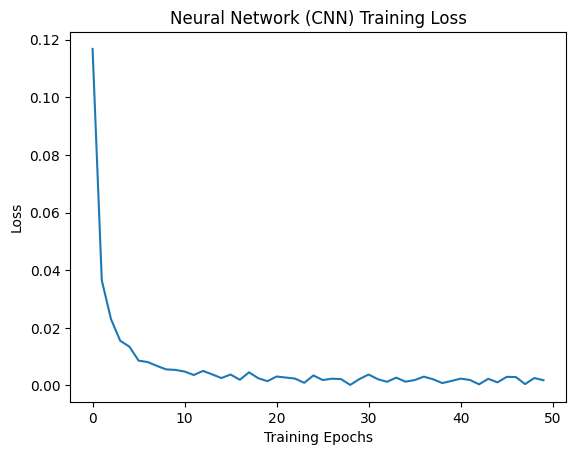

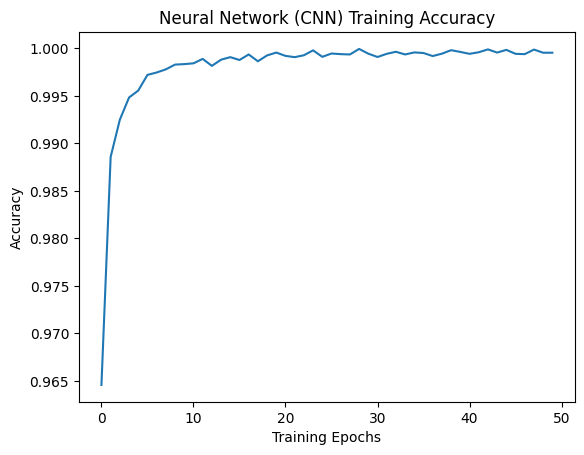

In [64]:
plt.figure()
plt.plot(np.arange(len(train_loss)), train_loss)
plt.title('Neural Network (CNN) Training Loss')
plt.ylabel('Loss')
plt.xlabel('Training Epochs')
plt.show()

plt.figure()
plt.plot(np.arange(len(train_acc)), train_acc)
plt.title('Neural Network (CNN) Training Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Training Epochs')
plt.show()